# DLP Pipeline Inference Workflow

## Introduction
Data Loss Prevention (DLP) is a set of tools, technologies, and processes designed to detect, monitor, and prevent the unauthorized transmission, or exposure of sensitive information. Modern DLP solutions include a combination of policy enforcement, content inspection, contextual analysis, and protective measures such as encryption, access restrictions, alerting, and remediation actions. This workflow shows an inference DLP pipeline solution that combines regex pattern matching with small language model (SLM) powered semantic analysis for data protection.

#### The Role of Modern DLP Systems

Effective DLP systems are essential in today’s enterprise and cloud environments to:

- Prevent Sensitive Data Leakage: Identify and mitigate exposure of personally identifiable information (PII), protected health information (PHI), credentials, and intellectual property.
- Ensure Regulatory Compliance: Meet data protection mandates such as GDPR, HIPAA, PCI-DSS, and ISO 27001.
- Detect Insider Threats: Monitor and flag suspicious access to sensitive data by internal actors.
- Secure Cloud and SaaS Workloads: Protect data in motion and at rest across hybrid and multi-cloud architectures.

#### Traditional DLP Limitations

- **High False Positives**: Rule-based systems generate excessive alerts
- **Limited Context**: Cannot understand semantic meaning
- **Performance Issues**: AI models too slow for real-time processing
- **Maintenance Overhead**: Constant pattern updates required

#### Hybrid Solution

To overcome these limitations, this workflow implements a hybrid DLP pipeline that couples:
- Regex-based pre-filtering for fast and scalable detection with high recall.
- Contextual entity validation using a lightweight SLM (e.g., DeBERTa-based GLiNER), reducing false positives by leveraging semantic information from the surrounding text window.

This architecture offers a pragmatic trade-off between speed, accuracy, and contextual sensitivity. This workflow shows a hybrid Data Loss Prevention (DLP) pipeline that combines:
- **Regex Pattern Matching**: Fast, rule-based detection using curated regular expression.
- **Context Aware Small Language Model**: A fine-tuned GLiNER-based small language model for PII detection. 




In [10]:
#!pip install -q -U nervaluate  gliner tqdm datasets

In [11]:
%load_ext autoreload
%autoreload 2

import json
import os
import time

import matplotlib.pyplot as plt
import pandas as pd
from regex_processor import RegexProcessor, GliNERProcessor,GPURegexEntityDetector

from util import (
    evaluate_results, run_benchmark_pipeline
)
from plot_util import (
    make_metrics_per_entity,
    visualize_benchmark_results,
    plot_detail_metrics,
    plot_latency_speedup
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Dataset creation and processing

### Synthetic Data for Safe Demonstration

We use the [gretelai/gretel-pii-masking-en-v1](https://huggingface.co/datasets/gretelai/gretel-pii-masking-en-v1) dataset to safely demonstrate DLP capabilities without exposing real sensitive information. The dataset is a synthetically generated collection of documents enriched with Personally Identifiable Information (PII) and Protected Health Information (PHI) entities spanning multiple domains.

 


In [12]:
from dataset_creation import load_and_process_datasets

print(" Loading Gretel synthetic dataset...")
gretel_dataset = load_and_process_datasets(['gretel'], num_samples=2000)

print(f" Dataset loaded: {len(gretel_dataset)} samples")
print(f"  Average text length: {gretel_dataset['source_text'].str.len().mean():.0f} characters")

# Display sample
sample_text = gretel_dataset['source_text'].iloc[0]
print(f"\n Sample text preview:\n{sample_text[:300]}...")


 Loading Gretel synthetic dataset...
Loading datasets: ['gretel']
 Dataset loaded: 2000 samples
  Average text length: 218 characters

 Sample text preview:
Mclaughlin-Peters, hereafter referred to as the Producer, agrees to license the exclusive rights to Danielle Lyons' music catalog, as defined in Exhibit A, to I1976524, hereafter referred to as the Licensee, for use in the Licensee's audiovisual production....


In [13]:
gretel_dataset['source_text'].iloc[0]

"Mclaughlin-Peters, hereafter referred to as the Producer, agrees to license the exclusive rights to Danielle Lyons' music catalog, as defined in Exhibit A, to I1976524, hereafter referred to as the Licensee, for use in the Licensee's audiovisual production."

## 2. Load and Configure Regex Patterns

First, we'll load the regex patterns from the benchmark patterns file.

In [14]:
# Load regex patterns
regex_file = "../data/regex_patterns.json"

if not os.path.exists(regex_file):
    # Create a basic set of patterns as fallback
    patterns = {
        "credit_card_number": [
            r"\b(?:4[0-9]{12}(?:[0-9]{3})?|5[1-5][0-9]{14}|3[47][0-9]{13}|3(?:0[0-5]|[68][0-9])[0-9]{11}|6(?:011|5[0-9]{2})[0-9]{12}|(?:2131|1800|35\d{3})\d{11}|(?:\d{4}[-\s]?){3}\d{4}|\d{16})\b"
        ],
        "ssn": [
            r"\b\d{3}[-\s]?\d{2}[-\s]?\d{4}\b"
        ],
        "email": [
            r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b"
        ],
        "phone_number": [
            r"\b(?:\+?1[-\.\s]?)?(?:\(\d{3}\)|\d{3})[-\.\s]?\d{3}[-\.\s]?\d{4}\b|\b\d{10}\b"
        ],
        "ipv4": [
            r"\b(?:\d{1,3}\.){3}\d{1,3}\b"
        ],
        "date": [
            r"\b\d{1,2}[\/\-\.]\d{1,2}[\/\-\.]\d{2,4}\b"
        ]
    }
else:
    with open(regex_file, 'r') as f:
        patterns = json.load(f)

print(f"Loaded {len(patterns)} regex pattern groups")
print(f"Configured {len(patterns)} pattern categories:")
for pattern_type in patterns.keys():
    print(f"  • {pattern_type}")

Loaded 42 regex pattern groups
Configured 42 pattern categories:
  • medical_record_number
  • date_of_birth
  • ssn
  • date
  • first_name
  • email
  • last_name
  • customer_id
  • employee_id
  • name
  • street_address
  • phone_number
  • ipv4
  • credit_card_number
  • license_plate
  • address
  • user_name
  • device_identifier
  • bank_routing_number
  • date_time
  • company_name
  • unique_identifier
  • biometric_identifier
  • account_number
  • city
  • certificate_license_number
  • time
  • postcode
  • vehicle_identifier
  • coordinate
  • country
  • api_key
  • ipv6
  • password
  • health_plan_beneficiary_number
  • national_id
  • tax_id
  • url
  • state
  • swift_bic
  • cvv
  • pin


In [15]:
sum(len(values) for key, values in patterns.items())

279

In [16]:
len(patterns['api_key'])

9

## 3. DLP Pipeline

The DLP workfow consists of several components. 

1. **Input Text/Documents**: Raw input data, such as text files or documents, are fed into the system.
   
2. **Preprocessing & Chunking**: If necessary the input text is cleaned, normalized, and divided into manageable chunks for efficient processing.

3. **Regex Scanner (Fast Pass)**: A high-speed, rule-based regex engine performs an initial scan to quickly identify potential sensitive data patterns.
This step filters an obvious matches, inlcudes context window tokens $|w|$ before and after detected match. We collect several regex rules to identify 42 entities. 

4. **SLM model (GLiNER Model)**: The remaining chunks undergo advanced analysis using a semantic AI model (e.g., GLiNER), which interprets data contextually to detect complex sensitive information that regex alone might miss.
A finetuned GLiNER model `gretelai/gretel-gliner-bi-small-v1.0` is used as base SLM model.The Gretel GLiNER model is a customized variant of the GLiNER base model, `knowledgator/gliner-bi-small-v1.0`, 
fine-tuned specifically for identifying Personally Identifiable Information (PII) and Protected Health Information (PHI). 

5. **Risk Analysis & Reporting**: The final results are assessed for risk, categorized, and formatted into actionable reports for further review or compliance purposes.


![dlp_pipeline_diagram.png](dlp_pipeline_diagram.png)

In [17]:

class DLPInputProcessor:
    """Handles input text processing and normalization for DLP pipeline"""
    
    def __init__(self, chunking_size: int = 1000, split_by_paragraphs: bool = False):
        self.chunking_size = chunking_size
        self.split_by_paragraphs = split_by_paragraphs
    
    def preprocess(self, text: str) -> list[str]:
        """
        Preprocess input text:
        1. Normalize whitespace
        2. Split into manageable chunks for processing
        """
        # Basic normalization
        normalized_text = text.replace('\r\n', '\n').replace('\r', '\n')
        
        if self.split_by_paragraphs:
            # For larger texts, split into chunks to optimize processing
            if len(normalized_text) > self.chunking_size:
                chunks = []
            # Split by paragraphs first to preserve content boundaries
            paragraphs = normalized_text.split('\n\n')
            current_chunk = ""
            
            for para in paragraphs:
                if len(current_chunk) + len(para) > self.chunking_size and current_chunk:
                    chunks.append(current_chunk)
                    current_chunk = para
                else:
                    current_chunk += ("\n\n" if current_chunk else "") + para
            
            if current_chunk:
                chunks.append(current_chunk)
            
            return chunks
        else:
            return [normalized_text]

class RiskScorer:
    """Analyzes findings to calculate risk scores and metrics"""
    
    def __init__(self):
        """Initialize with configuration for risk scoring"""
        
        self.type_weights = {
            "password": 85,
            "credit_card": 90,
            "ssn": 95,
            "address": 60,
            "email": 40,
            "phone_us": 45,
            "phone_numbers": 45,
            "ip_address": 30,
            "date": 20,
            "api_key": 80,
            "customer_id": 65,
            # Semantic categories
            "personal": 70,
            "financial": 85,
            "health": 75,
            "api_credentials": 75
        }
        
        # Default weight if type not in dictionary
        self.default_weight = 50
    
    def score(self, findings: list[dict[str, list]]) -> dict[str, list]:
        """
        Calculate risk scores based on findings
        
        Returns:
            Risk scoring results and metrics
        """
        if not findings:
            return {
                "risk_score": 0,
                "risk_level": "None",
                "data_types_found": [],
                "highest_confidence": 0.0,
                "severity_distribution": {"high": 0, "medium": 0, "low": 0}
            }
        
        # Calculate total weighted score
        total_score = 0
        severity_counts = {"high": 0, "medium": 0, "low": 0}
        
        for finding in findings:
            data_type = finding.get("data_type", finding["label"])
            
            # Get weight for this data type
            weight = self.type_weights.get(data_type, self.default_weight)
            
            # Adjust by confidence
            confidence = finding["score"]
            weighted_score = weight * confidence
            total_score += weighted_score
            
            # Count by severity
            if weight >= 80:
                severity_counts["high"] += 1
            elif weight >= 50:
                severity_counts["medium"] += 1
            else:
                severity_counts["low"] += 1
        
        # Normalize to 0-100 scale with diminishing returns for many findings
        import math
        max_score = 100
        normalization_factor = max(1, math.log2(len(findings) + 1)) * 20  # Adjust scaling factor
        
        # Calculate normalized risk score
        risk_score = min(max_score, total_score / normalization_factor)
        
        # Determine risk level from score
        risk_level = "Critical" if risk_score >= 80 else \
                     "High" if risk_score >= 60 else \
                     "Medium" if risk_score >= 40 else \
                     "Low" if risk_score >= 20 else "Minimal"
        
        # Get unique data types found
        data_types_found = list({finding.get("data_type", finding["label"]) 
                               for finding in findings})
        
        # Find highest confidence score
        highest_confidence = max(finding["score"] for finding in findings)
        
        return {
            "risk_score": int(risk_score),
            "risk_level": risk_level,
            "data_types_found": data_types_found,
            "highest_confidence": highest_confidence,
            "severity_distribution": severity_counts
        }



In [18]:

class DLPPipeline:
    """ DLP pipeline integrating components"""
    
    def __init__(self, 
                 regex_patterns: dict[str, list[str]], 
                 confidence_threshold: float = 0.7,
                 model_name: str = "gretelai/gretel-gliner-bi-small-v1.0",
                 context_window: int = 300):
        """Initialize the enhanced DLP pipeline"""
        self.input_processor = DLPInputProcessor(split_by_paragraphs=False)
        self.regex_processor = RegexProcessor(patterns=regex_patterns)
        self.gliner_processor = GliNERProcessor(
            confidence_threshold=confidence_threshold,
            context_window=context_window,
            model_name=model_name
        )
        self.risk_scorer = RiskScorer()
    
    def inference(self, document: str,
                  failback: bool = False) -> dict[str, list]:
        """Process a document through the DLP pipeline"""
        regex_findings = self.regex_processor.process(document)
        return self.gliner_processor.process(document, regex_findings, failback=failback)
    
    def process(self, document: str) -> dict[str, list]:
        """Process a document through the DLP pipeline"""
        start_time = time.time()
        
        # Stage 1: Input processing
        text_chunks = self.input_processor.preprocess(document)
        
        # Process metrics
        regex_times = []
        gliner_times = []
        all_findings = []
        
        # Process each chunk
        for chunk in text_chunks:
            # Stage 2: Regex processing with timing
            regex_start = time.time()
            regex_findings = self.regex_processor.process(chunk)
            regex_time = time.time() - regex_start
            regex_times.append(regex_time)
            
            # Stage 3: GLiNER processing with timing
            gliner_start = time.time()
            semantic_findings = self.gliner_processor.process(chunk, regex_findings)
            gliner_time = time.time() - gliner_start
            gliner_times.append(gliner_time)
            
            
            all_findings.extend(semantic_findings)
        
        # Stage 5: Risk scoring
        risk_assessment = self.risk_scorer.score(all_findings)
        
        # Calculate performance metrics
        end_time = time.time()
        total_processing_time = end_time - start_time
        total_regex_time = sum(regex_times)
        total_gliner_time = sum(gliner_times)
        
        # Create performance report
        performance_metrics = {
            "total_time": total_processing_time,
            "regex_time": total_regex_time,
            "gliner_time": total_gliner_time,
            "regex_percentage": (total_regex_time / total_processing_time) * 100 if total_processing_time > 0 else 0,
            "gliner_percentage": (total_gliner_time / total_processing_time) * 100 if total_processing_time > 0 else 0,
            "throughput": len(document) / total_processing_time if total_processing_time > 0 else 0
        }
        
        return {
            "findings": all_findings,
            "total_findings": len(all_findings),
            "risk_assessment": risk_assessment,
            "performance_metrics": performance_metrics,
            "document_length": len(document)
        }

## 4. Pipeline Document Processing   




In [19]:
test_documents = [
    {
        "title": "Patient Information",
        "content": """
PATIENT INFORMATION
Medical Record #: MRN-12345678
Name: John Smith
DOB: 01/15/1985
SSN: 123-45-6789
Address: 5678 Pine Avenue, Apt 302, Chicago, IL 60601
Phone: 773-555-1234
Email: jsmith@email.net
Insurance ID: INS-987654321

VISIT SUMMARY
Date: 03/22/2023
Time: 14:30
Provider: Dr. Sarah Johnson, MD (NPI: 1234567890)
Diagnosis: Hypertension (ICD-10: I10)
Medications: Lisinopril 10mg daily
Follow-up: 3 months
"""
    },
    {
        "title": "Config File with API Keys",
        "content": """
# Production API Configuration
api_key = "ak_live_HJd8e7h23hFxMznWcQE5TWqL"
api_secret = "sk_test_abcdefghijklmnopqrstuvwxyz12345"
debug = false

# Database Connection
DB_HOST = "db.example.com"
DB_USER = "admin"
DB_PASSWORD = "SecurePassword123!"
"""
    },
    {
        "title": "Order Receipt",
        "content": """
PURCHASE RECEIPT

Customer: Jane Doe
Email: jane.doe@example.com
Card: VISA ending in 4567
Transaction: $128.50

Shipping Address:
123 Main Street
Anytown, CA 94538
"""
    }
]

# Create the enhanced DLP pipeline
dlp_pipeline = DLPPipeline(
    regex_patterns=patterns,
    confidence_threshold=0.7,
    model_name="gretelai/gretel-gliner-bi-small-v1.0",
    context_window=300
)


# Process first document
document = test_documents[0]
print(f" Processing: {document['title']}")
results = dlp_pipeline.process(document['content'])

print(f"\n RESULTS:")
print(f"Total findings: {results['total_findings']}")
print(f"Risk score: {results['risk_assessment']['risk_score']}/100")
print(f"Risk level: {results['risk_assessment']['risk_level']}")
print(f"Processing time: {results['performance_metrics']['total_time']:.3f}s")


print(f"\n🎯 Detected data types:")
for data_type in results['risk_assessment']['data_types_found']:
    print(f"  • {data_type}")

print(f"\n🔍 Sample findings:")
for i, finding in enumerate(results['findings'][:3]):
    label = finding.get('label', 'Unknown')
    score = finding.get('score', 0)
    print(f"  {i+1}. {label} (confidence: {score:.3f})")

Fetching 9 files: 100%|██████████| 9/9 [00:00<00:00, 48272.04it/s]
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


 Processing: Patient Information

 RESULTS:
Total findings: 8
Risk score: 6/100
Risk level: Minimal
Processing time: 0.543s

🎯 Detected data types:
  • date
  • state
  • phone_number
  • postcode
  • health_plan_beneficiary_number
  • email
  • ssn
  • street_address

🔍 Sample findings:
  1. date (confidence: 0.957)
  2. ssn (confidence: 0.940)
  3. street_address (confidence: 0.945)


In [20]:
# process as inference output using valdiation dataset
results = dlp_pipeline.inference(gretel_dataset['source_text'][0])
print(results)

[{'start': 0, 'end': 17, 'text': 'Mclaughlin-Peters', 'label': 'company_name', 'score': 0.891257107257843}, {'start': 100, 'end': 108, 'text': 'Danielle', 'label': 'first_name', 'score': 0.9953271150588989}, {'start': 109, 'end': 114, 'text': 'Lyons', 'label': 'last_name', 'score': 0.9869977235794067}, {'start': 159, 'end': 167, 'text': 'I1976524', 'label': 'medical_record_number', 'score': 0.9971086382865906}]


##### Running batch of examples

In [21]:
def batch_process_documents(pipeline, documents):
    """Process multiple documents and aggregate results"""
    all_results = []
    total_findings = 0
    total_processing_time = 0
    total_document_length = 0
    
    for doc in documents:

        result = pipeline.process(doc)
        all_results.append(result.get('all_findings', []))
        
        total_findings += result['total_findings']
        total_processing_time += result['performance_metrics']['total_time']
        total_document_length += result['document_length']
    
    # Aggregate metrics
    avg_processing_time = total_processing_time / len(documents) if documents else 0
    avg_findings_per_doc = total_findings / len(documents) if documents else 0
    overall_throughput = total_document_length / total_processing_time if total_processing_time > 0 else 0
    
    # Print summary
    print(f"\n{'='*50}")
    print(f"Batch Processing Summary")
    print(f"{'='*50}")
    print(f"Documents processed: {len(documents)}")
    print(f"Total findings: {total_findings}")
    print(f"Average findings per document: {avg_findings_per_doc:.2f}")
    print(f"Total processing time: {total_processing_time:.3f} seconds")
    print(f"Average processing time: {avg_processing_time:.3f} seconds per document")
    print(f"Overall throughput: {overall_throughput:.2f} characters/second")
    
    return all_results

In [22]:
batch_results = batch_process_documents(dlp_pipeline,gretel_dataset['source_text'].iloc[:10].tolist())


Batch Processing Summary
Documents processed: 10
Total findings: 46
Average findings per document: 4.60
Total processing time: 1.004 seconds
Average processing time: 0.100 seconds per document
Overall throughput: 2303.11 characters/second


## 5. Evaluation 

Now we will evaluate the accuracy and performance of different approaches: Regex-only, GLiNER-only, and our Hybrid approach. 

### 5.1  Evaluation of models accuracy

In [23]:
dlp_pipeline = DLPPipeline(
    regex_patterns=patterns,
    confidence_threshold=0.3,
    model_name="gretelai/gretel-gliner-bi-small-v1.0",
    context_window=300
)

Fetching 9 files: 100%|██████████| 9/9 [00:00<00:00, 75497.47it/s]


We will make the performance of  GLiNER model, Hybrid model and Regex model. We use the dataset from `gretel` 


In [24]:
eval_data = run_benchmark_pipeline(gretel_dataset, dlp_pipeline, dlp_pipeline.regex_processor, dlp_pipeline.gliner_processor)

  0%|          | 0/2000 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


100%|██████████| 2000/2000 [02:57<00:00, 11.30it/s]


Now, we compare the results against the groundtruth using  [nervalue](https://github.com/MantisAI/nervaluate) library for `precision`, `recall`, and `F1` metrics.

The metrics includes five way of measuring the performance of the predicted NER entities. These metrics represent varying levels of correctness, from detecting the right entity type (regardless of span) to requiring exact span and label matches.
- Strict: Exact boundary surface string match and entity type
- Exact : Exact boundary match over the surface string, regardless of the type
- Partial: partial boundary match over the surface string, regardless of the type
- Type: some overlap between the system tagged entity and the gold annotation is required



In [25]:
dataset = "gretel"
all_results = pd.DataFrame()
benchmark_results = {}
for model in ['regex_results', 'hybrid_results', 'gliner_results']:
    # if model != 'regex_v5':
    #     continue
    print(f"Evaluating {model} for {dataset} dataset")
    results,  results_per_tag, result_indices, result_indices_by_tag = evaluate_results(gretel_dataset, eval_data[model], model=model, dataset=dataset)
    benchmark_results[model] = {
        'results': results,
        'results_per_tag': results_per_tag,
        'result_indices': result_indices,
        'result_indices_by_tag': result_indices_by_tag
    }
  
    
    print(results)
    print(f"-------------------------------- {model} --------------------------------")
    all_results = pd.concat([all_results, results])

Evaluating regex_results for gretel dataset
               ent_type  partial   strict     exact    missed  spurious
regex_results  0.139038  0.46405  0.11499  0.339193  0.027483  1.330265
-------------------------------- regex_results --------------------------------
Evaluating hybrid_results for gretel dataset
                ent_type   partial   strict     exact    missed  spurious
hybrid_results  0.937002  0.958506  0.92274  0.941943  0.005725  0.045116
-------------------------------- hybrid_results --------------------------------
Evaluating gliner_results for gretel dataset
                ent_type  partial    strict   exact    missed  spurious
gliner_results  0.958033  0.98076  0.954313  0.9721  0.006305  0.014945
-------------------------------- gliner_results --------------------------------


#### Overall performance metrics


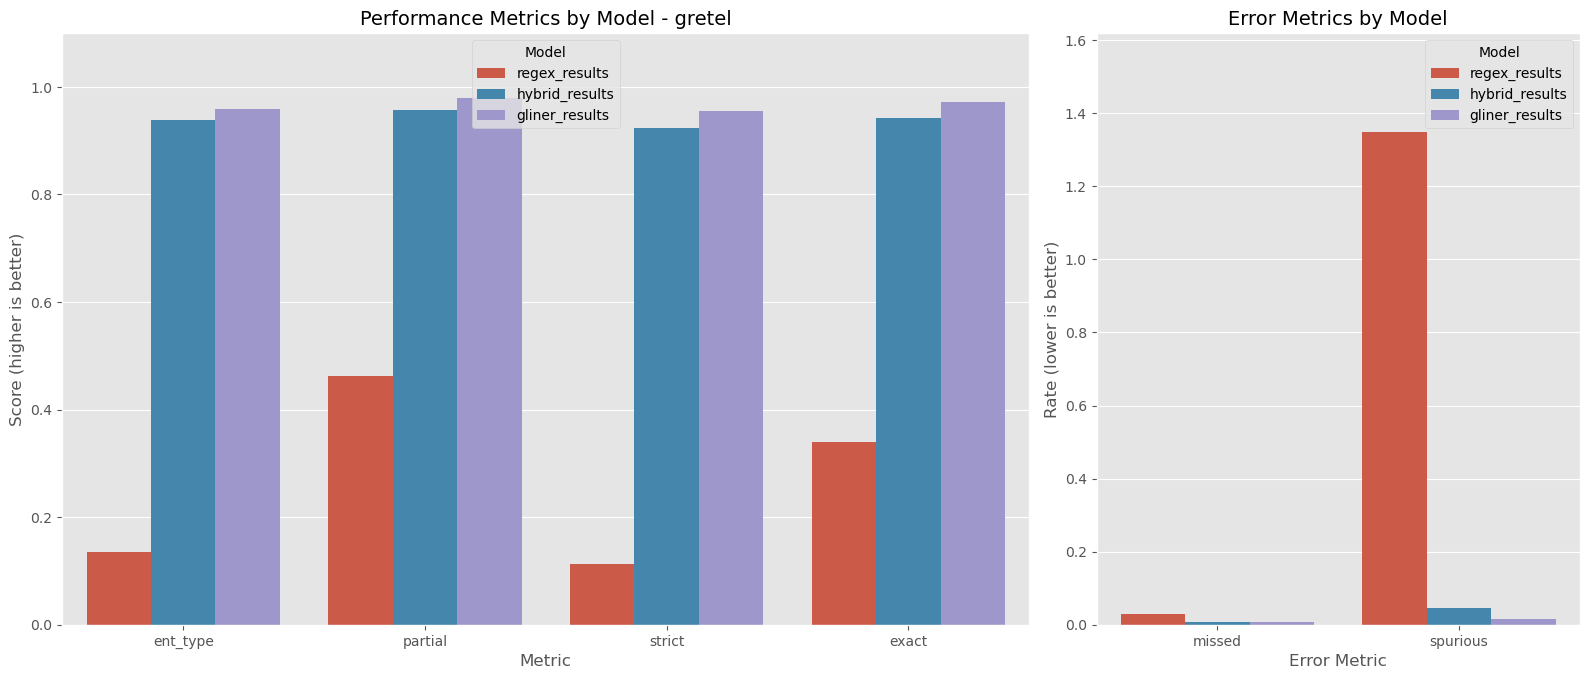

In [18]:
#output_img = f"results/benchmark_visualization_{dataset}_5k_{model_name}_{mode}.png"
fig = visualize_benchmark_results(
    all_results, 
    output_path=None,
    dataset_name=dataset
)

The evaluation results compare the three models used  in DLP `regex_only`, `hybrid`, and `GliNER_only`. Overall, the results shows, `regex_only` perform poorly across all metrics, especially on strict/exact span matching, 
indicating that rule-based detection struggles with precise boundary and semantic accuracy. 
GliNER based methods `GliNER_only` and `hybrid_results` are close in performance, but `GliNER_only`slightly outperforms. The `hybrid_results` are significantly better than regex, showing the benefit of context-aware verification.

For the error analysis plot, error metrics such as **missed** and **spurious** highlight the rate of false negatives and false positives, respectively.
The regex-only suffer from very high spurious error rate, showing they detect many irrelevant spans. On the other hand, the hybrid and GLiNER models maintain very low error rates in both categories, which demonstrates their improved precision and recall.

In summary, the hybrid model offers an effective middle ground by leveraging the speed of regex with the contextual intelligence of a small language model.

#### Performance per entity tag

We can measure the performance of individual entities and their corresponding metrics. This allows us to identify which entities are more challenging to detect than others.

<Figure size 600x800 with 0 Axes>

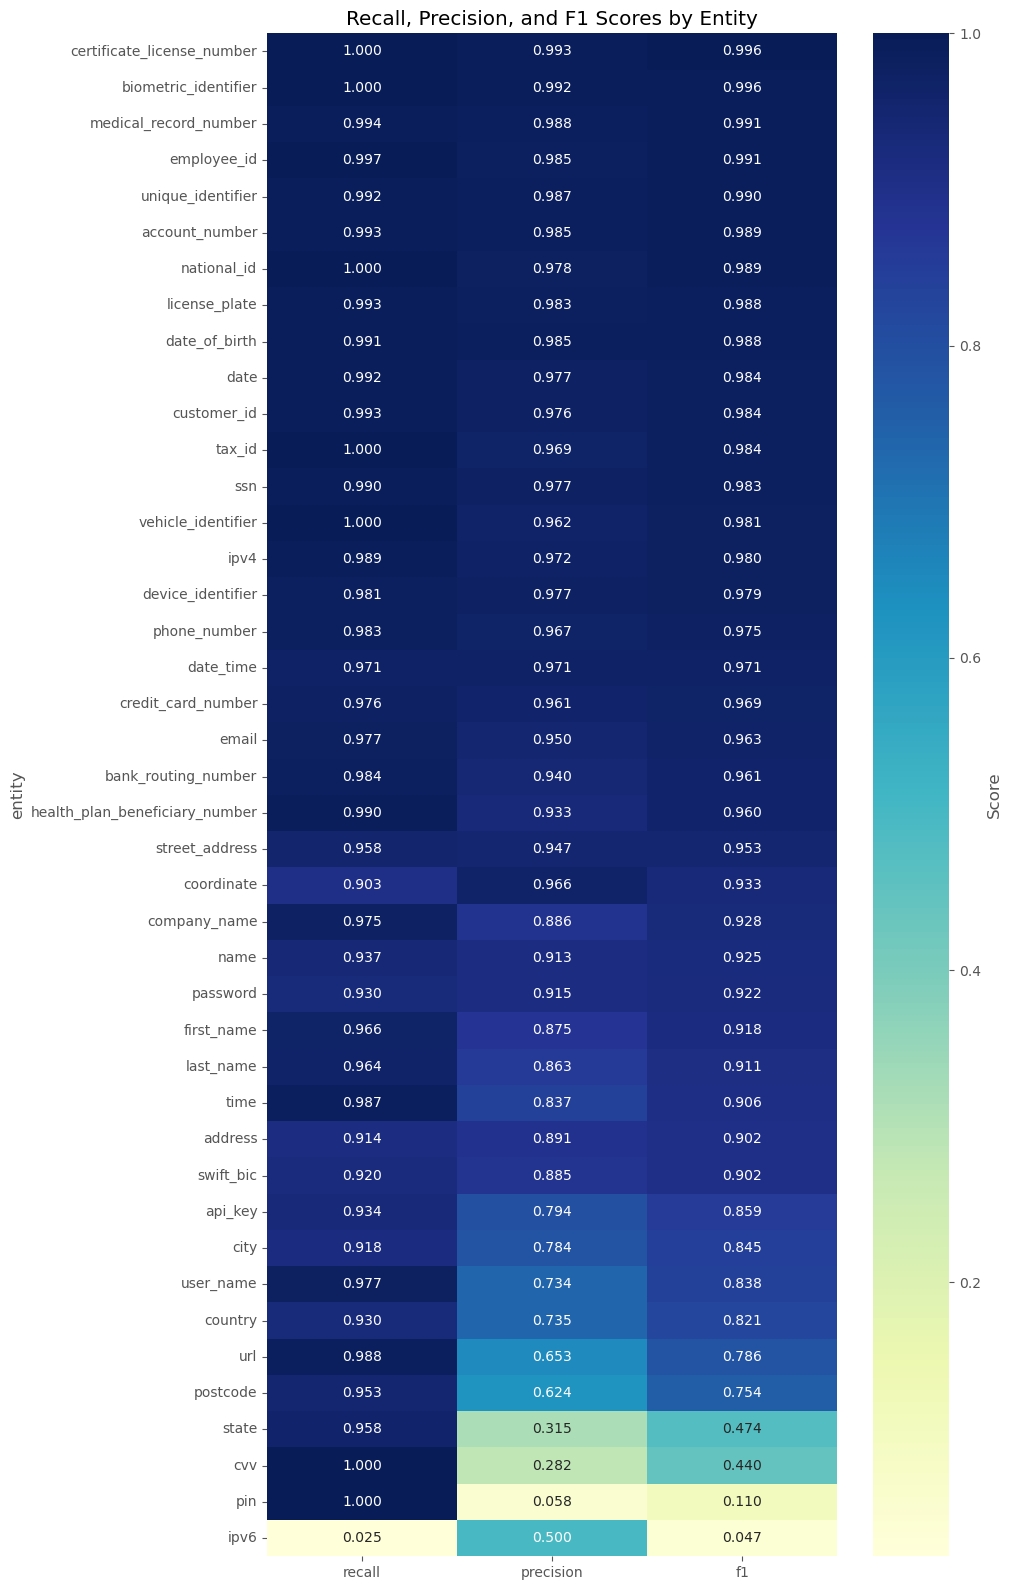

In [19]:
all_results_df,  results_per_tag, result_indices, result_indices_by_tag = list(benchmark_results['hybrid_results'].values())
metrics_df = make_metrics_per_entity(results_per_tag, metric="partial")
plot_detail_metrics(metrics_df)

This heatmap visualizes the recall, precision, and F1 scores for various PII detected using hybrid DLP pipeline. The heatmap shows that most structured identifiers (e.g., license numbers, IDs) are detected with high accuracy. Mid-tier entities like `emails` and `credit card numbers` perform reasonably well, 
while short or ambiguous entities such as `cvv`, `pin`, and `ipv6` generate large false alarm to accurately detect them, indicating they are the most challenging to detect accurately.


### 5.2 Benchmark Latency and Throughput 

In the next section, we evaluate the model’s latency. We augment the `gretel` example dataset with synthetic noise to increase its size and assess whether the hybrid model can leverage the fast `RegexProcessor` filtering mechanism to improve processing speed.

In [21]:
# Take few examples for demonstration
latency_dataset = gretel_dataset.iloc[:200]
latency_dataset.head()

,source_text,privacy_mask,source
0,"Mclaughlin-Peters, hereafter referred to as th...","[{'label': 'first_name', 'start': 100, 'end': ...",gretel
1,"{\n ""activationCode"": ""123456"",\n ""deviceId""...","[{'label': 'user_name', 'start': 89, 'end': 98...",gretel
2,"Imaging Order for Sean Byrd-Evans, DOB: 2003-0...","[{'label': 'first_name', 'start': 18, 'end': 2...",gretel
3,**Transport Order**\n\nOrder ID: 01405479508\n...,"[{'label': 'phone_number', 'start': 31, 'end':...",gretel
4,"Cargo Manifest for Flight ABC123, Departing Ch...","[{'label': 'phone_number', 'start': 188, 'end'...",gretel


In [24]:
import sys
# noisy non PII text
noise_text = """<p>simply dummy text of the printing and typesetting industry. When an unknown printer took a galley of type and scrambled it to make a type specimen book. 
It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. <br>
It was popularised in the earlier with the release of sheets containing"""

# Size estimate of nois text
mb_param= 30000 # MB
mb_parameters = [mb_param*i for i in range(0,6)]
for mb_param in mb_parameters:
    print(f"MB parameter: {mb_param}")
    print(f"Size of noise text: {sys.getsizeof(noise_text*mb_param) / 1024 / 1024} MB")
    print()

MB parameter: 0
Size of noise text: 3.910064697265625e-05 MB

MB parameter: 30000
Size of noise text: 10.128060340881348 MB

MB parameter: 60000
Size of noise text: 20.256081581115723 MB

MB parameter: 90000
Size of noise text: 30.384102821350098 MB

MB parameter: 120000
Size of noise text: 40.51212406158447 MB

MB parameter: 150000
Size of noise text: 50.64014530181885 MB



In [25]:
# Add random noise texts with variable size
latency_dataset['source_text'] = [ txt + noise_text* mb_parameters[i%len(mb_parameters)] for i, txt in enumerate(latency_dataset['source_text'])] 


/tmp/ipykernel_1400831/688315989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latency_dataset['source_text'] = [ txt + noise_text* mb_parameters[i%len(mb_parameters)] for i, txt in enumerate(latency_dataset['source_text'])]


In [28]:
print("Total files size in MB")
print(f"{sum(sys.getsizeof(text)/1024/1024/1024 for text in latency_dataset['source_text'].tolist())} GB")

Total files size in MB
4.905809523537755 GB


Running these large files takes long, lets run few examples to demonstrate the latency evaluation exercise.

In [35]:
latency_eval_data = run_benchmark_pipeline(latency_dataset.iloc[:10], dlp_pipeline, dlp_pipeline.regex_processor, dlp_pipeline.gliner_processor)

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/envs/rapids-25.04/lib/python3.12/site-packages/gliner/data_processing/processor.py:296: UserWarning: Sentence of length 2010045 has been truncated to 1024
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
 20%|██        | 2/10 [00:04<00:17,  2.21s/it]/opt/conda/envs/rapids-25.04/lib/python3.12/site-packages/gliner/data_processing/processor.py:296: UserWarning: Sentence of length 4020014 has been truncated to 1024
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
 30%|███       | 3/10 [00:13<00:34,  4.88s/it]/opt/conda/envs/rapids-25.04/lib/python3.12/site-packages/gliner/data_processing/processor.py:296: UserWarning: Sentence of length 6030049 has been truncated to 1024
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
 40%|████      | 4/10 [00:25<00:46,  7.83s/it]/opt/conda/envs/rapids-25.04/lib/python3.12/site-packages/gliner/data_processing/processor.py:296: UserWarnin

In [36]:

# Latency and throughput metrics
latency = [] 
for key, value in latency_eval_data['timing_metrics'].items():
    latency.append({'model': key, 'total_time': value['total_time'], 'Average per row': value['avg_latency'], 'throughput': value['throughput']})
df_latency = pd.DataFrame(latency)
df_latency.head()

,model,total_time,Average per row,throughput
0,regex,19.567723,1.956772,10.869483
1,hybrid,19.758647,1.975865,10.764454
2,gliner,51.575396,5.157540,4.123886


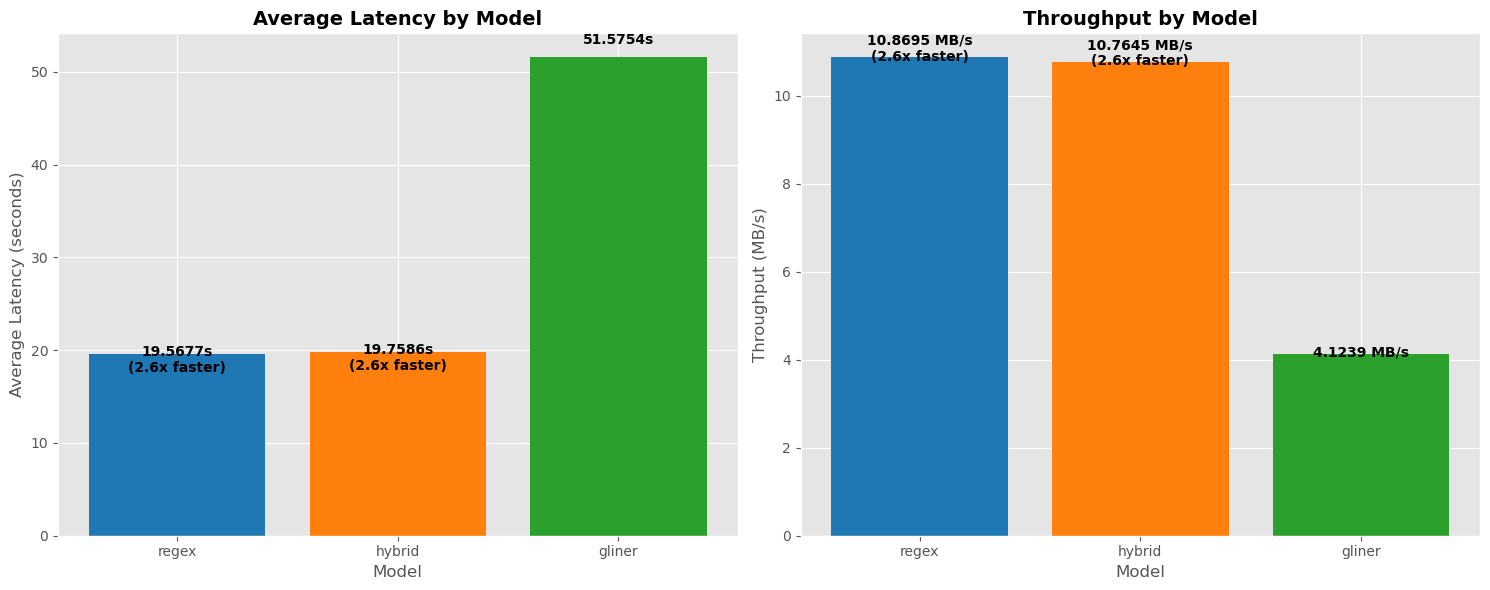

In [42]:
plot_latency_speedup(df_latency)

The **Average Latency by Model** chart shows the total time taken by each model to process a fixed workload. The `regex-based` model is the fastest, with an average latency of 43.71 seconds, followed closely by the `hybrid` model at 45.55 seconds. In contrast, the GLiNER model is significantly slower, requiring 119.12 seconds, making it roughly 2.6x slower than regex and hybrid. This indicates that the cost of GLiNER’s high accuracy (as seen in the previous chart) is increased computational time. 

The **Throughput by Model** chart measures how much data (in MB) each model processes per second. Both the regex and hybrid models achieve similar high throughput (~10.6 MB/s), whereas the GLiNER model lags behind at 3.91 MB/s, reflecting its 2.6x times slower inference speed and higher resource demand.

In summary, this experiment highlights a trade-off,  while the GLiNER model provides superior accuracy and minimal error rates, it suffers from significantly lower efficiency. On the other hand, the hybrid model strikes a balance, maintaining near-GLiNER accuracy while preserving high speed and throughput close to regex. This makes the hybrid architecture particularly attractive for real-time or large-scale DLP systems where both precision and efficiency are essential. Regex remains the fastest but is only suitable where rough pattern-based detection appropriate.

# Summary

This workflow shows the effectiveness a hybrid DLP architecture, which combines the speed and efficiency of regex pattern matching with the semantic understanding capabilities of AI models. The results shows the combined approach delivers better performance compared to either method used in isolation,
providing both high accuracy and the scalability required for enterprise deployments.


# Reference

1. https://huggingface.co/datasets/gretelai/gretel-pii-masking-en-v1
2. https://huggingface.co/gretelai/gretel-gliner-bi-small-v1.0
3. https://aclanthology.org/2024.naacl-long.300/ 